In [12]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats as st
import matplotlib.pyplot as plt
import random

In [13]:
df = pd.read_csv("/home/divya/UBERT/CSV_files/Early_Exit_Confidence_data_imdb_max_exits(3,6,12)_difference.csv")
df.head(5)

,Unnamed: 0,Thi_layer_P,Six_layer_P,Last_layer,PProb_thi,PProb_six,PProb_las,True_labels
0,0,1,1,1,0.665648,0.812874,0.959256,1
1,1,0,0,0,0.621514,0.683041,0.609833,1
2,2,1,1,1,0.655199,0.801864,0.879779,1
3,3,1,1,1,0.841005,0.871144,0.942345,1
4,4,1,1,1,0.690995,0.637939,0.902713,1


In [14]:
action_set_1 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [15]:
# accuracy_imdb = []
# for j in df.columns:
#   accuracy = 0
#   for i in range(df.shape[0]):
#       if df[j][i] == df['True_labels'][i]:
#           accuracy += 1
#       else:
#           pass
#   print("Accuracy = ", accuracy/df.shape[0])
#   accuracy_imdb.append(accuracy)

In [16]:
print([action_set_1[0], action_set_1[1]])

[0.5, 0.6]


In [17]:
action_set = []
act_mat = np.zeros([len(action_set_1), len(action_set_1), 2])
for i in range(act_mat.shape[0]):
    for j in range(act_mat.shape[1]):
        # if i>j:     
        act_mat[i][j] = np.array([action_set_1[i], action_set_1[j]])
        action_set.append(act_mat[i][j])

In [18]:
len(action_set)

36

In [19]:
print((action_set))

[array([0.5, 0.5]), array([0.5, 0.6]), array([0.5, 0.7]), array([0.5, 0.8]), array([0.5, 0.9]), array([0.5, 1. ]), array([0.6, 0.5]), array([0.6, 0.6]), array([0.6, 0.7]), array([0.6, 0.8]), array([0.6, 0.9]), array([0.6, 1. ]), array([0.7, 0.5]), array([0.7, 0.6]), array([0.7, 0.7]), array([0.7, 0.8]), array([0.7, 0.9]), array([0.7, 1. ]), array([0.8, 0.5]), array([0.8, 0.6]), array([0.8, 0.7]), array([0.8, 0.8]), array([0.8, 0.9]), array([0.8, 1. ]), array([0.9, 0.5]), array([0.9, 0.6]), array([0.9, 0.7]), array([0.9, 0.8]), array([0.9, 0.9]), array([0.9, 1. ]), array([1. , 0.5]), array([1. , 0.6]), array([1. , 0.7]), array([1. , 0.8]), array([1. , 0.9]), array([1., 1.])]


# One_UBERT_Cycle

In [22]:
def one_cycle(df, action_set, overhead):
    c_i_data_thi = []
    for i in df["PProb_thi"]:
        c_i_data_thi.append(i)

    c_i_data_six = []
    for i in df["PProb_six"]:
        c_i_data_six.append(i)

    c_l_data = []
    for i in df["PProb_las"]:
        c_l_data.append(i)
        
    # action_set_1 = [0.10*((i+10)/3) for i in range(20)]
    # action_set = []
    # for i in range(len(action_set_1)):
    #     if i%2 == 0:
    #         action_set.append(action_set_1[i])
    
    
    def reward(c_i_thi, c_i_six, c_l, action, overhead):
        if c_i_thi >= action_set[action][0]:
            reward = 0
        elif c_i_six >= action_set[action][1]:
            reward = c_i_six - c_i_thi - overhead[0] 
        else:
            reward = c_l - c_i_thi - overhead[0] - overhead[1]
        return reward
    
    
    def next_action(Q, c_tilde, N, t):
      # Q is the list of rewards
      # c_tilde is the hyperparameter
      # N is the number of times an action is chosen
        next_a = []
        for i in range(len(action_set)):

            next_a.append(Q[i] + c_tilde*((np.log(t)/N[i])**(0.5)))

        return next_a.index(max(next_a))
    
    
    def update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, chosen_action, overhead):
        n = N[chosen_action]
        N[chosen_action] += 1
        Q[chosen_action] = (n*Q[chosen_action] + reward(c_i_data_thi[t], c_i_data_six[t], c_l_data[t], chosen_action, overhead))/N[chosen_action]
        return Q, N
    
    

    def initialize(Q, N, action_set, c_i_data_thi, c_i_data_six, c_l_data, overhead):
        for t in range(len(action_set)):
            update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, t, overhead)
        # print(N)
        return Q, N
    
    
    
    
    def oracle_action(overhead):
        oracle_reward = []
        for i in action_set:
            o_reward = 0 
            for t in range(df.shape[0]):
                if c_i_data_thi[t] >= i[0]:
                    reward = 0
    #                 predictions.append(df["Fou_layer_P"][t])
                elif c_i_data_six[t] >= i[1]:
                    reward = c_i_data_six[t] - c_i_data_thi[t] - overhead[0] 
                else:
                    reward = c_l_data[t] - c_i_data_thi[t] - overhead[0] - overhead[1] 
                o_reward += reward
    #         print(oracle_reward)
            oracle_reward.append(o_reward/df.shape[0])

        return oracle_reward.index(max(oracle_reward)), oracle_reward
    oracle_action, o_reward = oracle_action(overhead)
    
    
    print("Oracle action =====> ", oracle_action)
    
    
    
    def one_UCB_cycle(Q, N, c_tilde, c_i_data_thi, c_i_data_six, c_l_data, overhead, df):
        action_chosen = []
        predictions = []
        rewards = []
        count_1 = 0
        count_2 = 0
        for t in range(df.shape[0]):
            if t < len(action_set):
                action = action_set[t]
                action_chosen.append(action)
                if c_i_data_thi[t] >= action_set[t][0]:
                    reward = 0
                    predictions.append(df["Thi_layer_P"][t])
                    rewards.append(reward)
                elif c_i_data_six[t] >= action_set[t][1]:
                    reward = c_i_data_six[t] - c_i_data_thi[t] - overhead[0]
                    predictions.append(df["Six_layer_P"][t])
                    rewards.append(reward)
                else:
                    reward = c_l_data[t] - c_i_data_thi[t] - overhead[0] - overhead[1]
                    predictions.append(df["Last_layer"][t])
                    rewards.append(reward)

            else:

                action = next_action(Q, c_tilde, N, t)
                # print(action)
                action_chosen.append(action)
                if c_i_data_thi[t] >= action_set[action][0]:
                    reward = 0
                    predictions.append(df["Thi_layer_P"][t])
                    rewards.append(reward)
                    count_1+=1
                    for i in range(len(action_set)):
                        if action_set[i][0] == action_set[action][0] and action_set[i][1] != action_set[action][1]:
                            Q, N = update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, i, overhead)
                        elif action_set[i][0] < action_set[action][0]:
                            Q, N = update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, i, overhead)
                        else:
                            pass
                elif c_i_data_six[t] >= action_set[action][1]:
                    reward = c_i_data_six[t] - c_i_data_thi[t] - overhead[0]
                    predictions.append(df["Six_layer_P"][t])
                    rewards.append(reward)
                    count_2+=1  
                    # Q, N = update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, action, overhead)
                    for i in range(len(action_set)):
                        if action_set[i][0] > action_set[action][0] and action_set[i][1] < action_set[action][1]:
                            Q, N = update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, i, overhead)
                        else:
                            pass
                else:
                    reward = c_l_data[t] - c_i_data_thi[t] - overhead[0] - overhead[1]
                    predictions.append(df["Last_layer"][t])
                    rewards.append(reward)
                    for i in range(len(action_set)):
                        if action_set[i][0] > action_set[action][0] and action_set[i][1] > action_set[action][1]:
                            Q, N = update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, i, overhead)
                        else:
                            pass
                    
                    # Q, N = update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, action, overhead)
                Q, N = update_parameters(Q, N, t, c_i_data_thi, c_i_data_six, c_l_data, action, overhead)
                

        return action_chosen, predictions, rewards, Q, N, count_1, count_2
    
    
    Q = [0 for i in range(len(action_set))]
    N = [0 for i in range(len(action_set))]
    c_tilde = 2
    Q, N = initialize(Q, N, action_set, c_i_data_thi,c_i_data_six, c_l_data, overhead)
    action, preds, rewards, Q, N, count_1, count_2 = one_UCB_cycle(Q, N, c_tilde, c_i_data_thi, c_i_data_six, c_l_data, overhead , df)
    
    optimal_action = Q.index(max(Q))
    print("Optimal_action is ", optimal_action)

    
    
    preds = []
    count = 0
    oracle_reward = []
    for i in range(df.shape[0]):
        
        if c_i_data_thi[i] > action_set[oracle_action][0]:
            reward = 0
            count += 1
            preds.append(df["Thi_layer_P"][i])
            oracle_reward.append(reward)
        elif c_i_data_six[i] > action_set[oracle_action][1]:
            reward = c_i_data_six[i] - c_i_data_thi[i] - overhead[0]
            count += 1
            preds.append(df["Six_layer_P"][i])
            oracle_reward.append(reward)
        else:
            preds.append(df["Last_layer"][i])
            reward = c_l_data[i] - c_i_data_thi[i] - overhead[0] - overhead[1]
            oracle_reward.append(reward)
                
    oracle_reward = np.array(oracle_reward)
    rewards = np.array(rewards)
    regret = (oracle_reward-rewards)
    cumulative_regret = abs(np.cumsum(regret))
    
    
    return cumulative_regret, count_1, count_2, action_set[optimal_action]

In [25]:
one_cycle(df, action_set, overhead = [0.1, 0.06])

Oracle action =====>  7
Optimal_action is  24


(array([  0.       ,   0.       ,   0.       , ..., 568.8227761,
        568.8227761, 568.8227761]),
 4959,
 14349,
 array([0.9, 0.5]))

In [54]:
idx = []
for i in range(df.shape[0]):
    if i%50 == 0:
        idx.append(i)

In [55]:
num_cycles = 5
reg_lis = []



for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg,_,_,_ = one_cycle(df, action_set, overhead = [0.06, 0.04])


    reg_lis.append([cum_reg[j] for j in idx])
    
reg_lis = np.array(reg_lis)

Oracle action =====>  4
Optimal_action is  8
Oracle action =====>  4
Optimal_action is  5
Oracle action =====>  4
Optimal_action is  5
Oracle action =====>  4
Optimal_action is  7
Oracle action =====>  4
Optimal_action is  5


In [569]:
len(reg_lis[0])

500

In [570]:
lower = []
upper = []

for i in range(len(reg_lis[0])):

    intrval = st.t.interval(alpha=0.95, df=len(reg_lis[:,i])-1,
            loc=np.mean(reg_lis[:,i]),
            scale=st.sem(reg_lis[:,i]))
        
    lower.append(intrval[0])
    upper.append(intrval[1])

In [571]:
len(lower)

500

# Other-Exit

In [226]:
def one_action_cycle(df, action_set, action, overhead):
    c_i_data_thi = []
    for i in df["PProb_thi"]:
        c_i_data_thi.append(i)

    c_i_data_six = []
    for i in df["PProb_six"]:
        c_i_data_six.append(i)

    c_l_data = []
    for i in df["PProb_las"]:
        c_l_data.append(i)

    # number_of_actions = 10
    # action_set = [0.10*((i+10)/2) for i in range(number_of_actions)]
        
    # action_set_1 = [0.10*((i+10)/3) for i in range(20)]
    # action_set = []
    # for i in range(len(action_set_1)):
    #     if i%2 == 0:
    #         action_set.append(action_set_1[i])
    # print(action_set)
    
 
    def oracle_action(overhead):
        oracle_reward = []
        for i in action_set:
            o_reward = 0 
            for t in range(df.shape[0]):
                if c_i_data_thi[t] >= i[0]:
                    reward = 0
    #                 predictions.append(df["Fou_layer_P"][t])
                elif c_i_data_six[t] >= i[1]:
                    reward = c_i_data_six[t] -  c_i_data_thi[t] - overhead[0]
                else:
                    reward = c_l_data[t] - c_i_data_thi[t] - overhead[0] - overhead[1]
                o_reward += reward
    #         print(oracle_reward)
            oracle_reward.append(o_reward/df.shape[0])

        return oracle_reward.index(max(oracle_reward)), oracle_reward
    oracle_action, o_reward = oracle_action(overhead)
    
    
    print("Oracle action =====> ", oracle_action)
    
    
    preds = []
    count = 0
    oracle_reward = []
    for i in range(df.shape[0]):
        if c_i_data_thi[i] > action_set[oracle_action][0]:
            reward = 0
            count += 1
            preds.append(df["Thi_layer_P"][i])
            oracle_reward.append(reward)
        elif c_i_data_six[i] >= action_set[oracle_action][1]:
            reward = c_i_data_six[i] -  c_i_data_thi[i] - overhead[0]
            preds.append(df["Six_layer_P"][i])
            oracle_reward.append(reward)
        else:
            preds.append(df["Last_layer"][i])
            reward = c_l_data[i] - c_i_data_thi[i] - overhead[0] - overhead[1]
            oracle_reward.append(reward)
    
    
#     action = random.choice(action_set)
    print("Action is ", action)
    
#     preds = []
#     count_1 = 0
    rewards = []
    for i in range(df.shape[0]):
        
        if c_i_data_thi[i] >= action[0]:
            reward = 0
#                 count_1 += 1
            preds.append(df["Thi_layer_P"][i])
            rewards.append(reward)
        elif c_i_data_six[i] >= action[1]:
            reward = c_i_data_six[i] - c_i_data_thi[i] - overhead[0]
#                 count_1 += 1
            preds.append(df["Six_layer_P"][i])
            rewards.append(reward)
        else:
            preds.append(df["Last_layer"][i])
            reward = c_l_data[i] - c_i_data_thi[i] - overhead[0] - overhead[1]
            rewards.append(reward)
    
                
    oracle_reward = np.array(oracle_reward)
    rewards = np.array(rewards)
    regret = (oracle_reward-rewards)
    cumulative_regret = abs(np.cumsum(regret))
    # print(oracle_reward,'\n', rewards)
    
    
    return cumulative_regret

In [227]:
reg_lis_3 = []

for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_3 = one_action_cycle(df, action_set, [0.5, 0.5], overhead = [0.06, 0.04])  
    reg_lis_3.append([cum_reg_3[j] for j in idx])
    
reg_lis_3 = np.array(reg_lis_3)

Oracle action =====>  2
Action is  [0.5, 0.5]
Oracle action =====>  2
Action is  [0.5, 0.5]
Oracle action =====>  2
Action is  [0.5, 0.5]
Oracle action =====>  2
Action is  [0.5, 0.5]
Oracle action =====>  2
Action is  [0.5, 0.5]


In [228]:
print(reg_lis_3)

[[2.37580440e-01 1.00717319e+00 1.26914087e+00 ... 1.06606444e+04
  1.06624674e+04 1.06640965e+04]
 [0.00000000e+00 3.00805800e-01 2.00150289e+00 ... 1.06627953e+04
  1.06634781e+04 1.06644543e+04]
 [0.00000000e+00 2.06223994e+00 3.05288888e+00 ... 1.06618542e+04
  1.06637196e+04 1.06642094e+04]
 [1.54345000e-03 4.48046060e-01 2.53044199e+00 ... 1.06607370e+04
  1.06621207e+04 1.06634641e+04]
 [4.02675000e-02 1.01745275e+00 4.78274700e-02 ... 1.06635639e+04
  1.06645385e+04 1.06647254e+04]]


In [528]:
lower_3 = []
upper_3 = []

for i in range(len(reg_lis[0])):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_3[:,i])-1,
              loc=np.mean(reg_lis_3[:,i]),
              scale=st.sem(reg_lis_3[:,i]))

        
    lower_3.append(intrval[0])
    upper_3.append(intrval[1])

In [529]:
len(lower_3)

500

# $\alpha = 0.8$

In [530]:
reg_lis_4 = []

for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_4 = one_action_cycle(df, action_set, [0.8, 0.8], overhead = [0.06, 0.04])

        
    reg_lis_4.append([cum_reg_4[j] for j in idx])
    
reg_lis_4 = np.array(reg_lis_4)

Oracle action =====>  3
Action is  [0.8, 0.8]
Oracle action =====>  3
Action is  [0.8, 0.8]
Oracle action =====>  3
Action is  [0.8, 0.8]
Oracle action =====>  3
Action is  [0.8, 0.8]
Oracle action =====>  3
Action is  [0.8, 0.8]


In [531]:
print(reg_lis_4)

[[0.00000000e+00 7.03806900e-01 1.70017717e+00 ... 4.94002854e+02
  4.95103253e+02 4.96382100e+02]
 [2.22744500e-01 1.73972566e+00 3.40282707e+00 ... 4.94036876e+02
  4.95167687e+02 4.96271582e+02]
 [0.00000000e+00 1.24530066e+00 1.79292560e+00 ... 4.93264847e+02
  4.94498502e+02 4.95970480e+02]
 [1.78555700e-02 6.42832400e-02 4.56730960e-01 ... 4.91908433e+02
  4.94311654e+02 4.95240447e+02]
 [0.00000000e+00 8.99576330e-01 1.79825843e+00 ... 4.93006557e+02
  4.93806218e+02 4.94907875e+02]]


In [532]:
upper_4 = []
lower_4 = []

for i in range(len(reg_lis[0])):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_4[:,i])-1,
              loc=np.mean(reg_lis_4[:,i]),
              scale=st.sem(reg_lis_4[:,i]))
        
    lower_4.append(intrval[0])
    upper_4.append(intrval[1])

# $\alpha = 0.9$  

In [533]:
reg_lis_5 = []
for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_5 = one_action_cycle(df, action_set, [0.9, 0.8], overhead = [0.06, 0.04])
        
    reg_lis_5.append([cum_reg_5[j] for j in idx])
    
reg_lis_5 = np.array(reg_lis_5)

Oracle action =====>  3
Action is  [0.9, 0.8]
Oracle action =====>  3
Action is  [0.9, 0.8]
Oracle action =====>  3
Action is  [0.9, 0.8]
Oracle action =====>  3
Action is  [0.9, 0.8]
Oracle action =====>  3
Action is  [0.9, 0.8]


In [534]:
print(reg_lis_5)

[[0.00000000e+00 7.78569000e-01 1.22367479e+00 ... 5.53457701e+02
  5.54583473e+02 5.56572528e+02]
 [3.37096000e-02 8.28488520e-01 2.31399592e+00 ... 5.54128650e+02
  5.55012380e+02 5.56032354e+02]
 [1.00738500e-01 2.96955230e-01 1.47895032e+00 ... 5.55597403e+02
  5.56813232e+02 5.56842206e+02]
 [0.00000000e+00 1.40246080e+00 2.27660586e+00 ... 5.53728575e+02
  5.54863998e+02 5.56035799e+02]
 [0.00000000e+00 7.81011600e-01 2.39249820e+00 ... 5.54857343e+02
  5.56460768e+02 5.57065170e+02]]


In [535]:
lower_5 = []
upper_5 = []

for i in range(len(reg_lis[0])):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_5[:,i])-1,
              loc=np.mean(reg_lis_5[:,i]),
              scale=st.sem(reg_lis_5[:,i]))
        
    lower_5.append(intrval[0])
    upper_5.append(intrval[1])

In [536]:
len(lower_5)

500

# $Final-Exit$ 

In [537]:
reg_lis_fin = []
for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_fin = one_action_cycle(df, action_set, [1.0, 0.9], overhead = [0.06, 0.04])
        
    reg_lis_fin.append([cum_reg_fin[j] for j in idx])
    
reg_lis_fin = np.array(reg_lis_fin)

Oracle action =====>  3
Action is  [1.0, 0.9]
Oracle action =====>  3
Action is  [1.0, 0.9]
Oracle action =====>  3
Action is  [1.0, 0.9]
Oracle action =====>  3
Action is  [1.0, 0.9]
Oracle action =====>  3
Action is  [1.0, 0.9]


In [538]:
print(reg_lis_fin)

[[4.66044700e-02 2.44747277e+00 3.70055990e+00 ... 1.24770937e+03
  1.24997572e+03 1.25416903e+03]
 [0.00000000e+00 1.57267035e+00 3.36576400e+00 ... 1.24662233e+03
  1.24969114e+03 1.25336445e+03]
 [0.00000000e+00 2.69927069e+00 6.03301644e+00 ... 1.24996734e+03
  1.25168095e+03 1.25402427e+03]
 [6.97896500e-02 2.05443731e+00 4.14554593e+00 ... 1.24761464e+03
  1.25023237e+03 1.25339625e+03]
 [7.16353000e-02 1.82834798e+00 4.17145488e+00 ... 1.24888419e+03
  1.25127419e+03 1.25368540e+03]]


In [539]:
lower_fin = []
upper_fin = []

for i in range(len(reg_lis[0])):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_fin[:,i])-1,
              loc=np.mean(reg_lis_fin[:,i]),
              scale=st.sem(reg_lis_fin[:,i]))
        
    lower_fin.append(intrval[0])
    upper_fin.append(intrval[1])

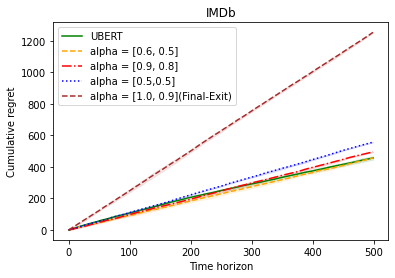

In [540]:
x = [i for i in range(len(idx))]
plt.plot(reg_lis.mean(axis = 0) ,'g', label="UBERT",linestyle = 'solid')
plt.fill_between(x, lower, upper, color='green', alpha=0.1)
plt.plot(reg_lis_3.mean(axis = 0) ,'orange', label="alpha = [0.6, 0.5]", linestyle = 'dashed')
plt.fill_between(x, lower_3, upper_3, color='orange', alpha=0.1)
plt.plot(reg_lis_4.mean(axis = 0) ,'red', label="alpha = [0.9, 0.8]", linestyle = 'dashdot')
plt.fill_between(x, lower_4, upper_4, color='red', alpha=0.1)
plt.plot(reg_lis_5.mean(axis = 0) ,'blue', label="alpha = [0.5,0.5]",linestyle = 'dotted')
plt.fill_between(x, lower_5, upper_5, color='blue', alpha=0.1)
plt.plot(reg_lis_fin.mean(axis = 0) ,'brown', label="alpha = [1.0, 0.9](Final-Exit)",linestyle = 'dashed')
plt.fill_between(x, lower_fin, upper_fin, color='brown', alpha=0.1)
plt.legend()
plt.xlabel("Time horizon")
plt.ylabel("Cumulative regret")
plt.title("IMDb")
plt.savefig('/home/divya/UBERT/Regret_plot_reduced/Regret_plot_imdb.pdf')
plt.show()

In [19]:
# num_cycles = 5
def accuracy_lat_calcu(df, optimal_action, overhead = [0.06, 0.04]):
    c_i_data_thi = []
    for i in df["PProb_thi"]:
        c_i_data_thi.append(i)

    c_i_data_six = []
    for i in df["PProb_six"]:
        c_i_data_six.append(i)

    c_l_data = []
    for i in df["PProb_las"]:
        c_l_data.append(i)

    preds = []
    count_1 = 0
    count_2 = 0
    for i in range(df.shape[0]):
        
        if c_i_data_thi[i] >= optimal_action[0]:
            # reward = 0
            count_1+=1
#                 count_1 += 1
            preds.append(df["Thi_layer_P"][i])
        elif c_i_data_six[i] >= optimal_action[1]:
            # reward = c_i_data_six[i] - c_i_data_thi[i] - overhead[0]
            count_2+=1  
            preds.append(df["Six_layer_P"][i])
            # rewards.append(reward)
        else:
            preds.append(df["Last_layer"][i])
            # reward = c_l_data[i] - c_i_data_thi[i] - overhead[0] - overhead[1]
            # rewards.append(reward)
    accuracy = 0
    for i in range(df.shape[0]):
        if preds[i] == df["True_labels"][i]:
            accuracy+=1
        else:
            pass
    return accuracy/df.shape[0], count_1/df.shape[0], count_2/df.shape[0]

    

In [20]:
num_cycles = 5
accuracy_lis = []
latency_lis = []
for i in range(num_cycles):
    df = df.sample(frac = 1)
    _,_,_,optimal_action = one_cycle(df, action_set, overhead = [0.06, 0.04])
    accuracy, count_1, count_2 = accuracy_lat_calcu(df, optimal_action, overhead = [0.06, 0.04])
    latency = count_1+count_2
    print("Optimal action is:", optimal_action,
          "\n=============================\n Fraction of Exits at first layer",count_1,
          "\n=============================\n Fraction of Exits at second layer", count_2,
          "\n=============================\n Total latency", 1-(count_1+count_2)
              )
    accuracy_lis.append(accuracy)
    latency_lis.append(latency)
accuracy_lis = np.array(accuracy_lis)
latency_lis = np.array(latency_lis)
    

Oracle action =====>  44
Optimal_action is  54
Optimal action is: [0.9 0.9] 
 Fraction of Exits at first layer 0.46788940726326844 
 Fraction of Exits at second layer 0.3183500283053041 
 Total latency 0.21376056443142744
Oracle action =====>  44
Optimal_action is  54
Optimal action is: [0.9 0.9] 
 Fraction of Exits at first layer 0.46788940726326844 
 Fraction of Exits at second layer 0.3183500283053041 
 Total latency 0.21376056443142744
Oracle action =====>  44
Optimal_action is  54
Optimal action is: [0.9 0.9] 
 Fraction of Exits at first layer 0.46788940726326844 
 Fraction of Exits at second layer 0.3183500283053041 
 Total latency 0.21376056443142744
Oracle action =====>  44
Optimal_action is  54
Optimal action is: [0.9 0.9] 
 Fraction of Exits at first layer 0.46788940726326844 
 Fraction of Exits at second layer 0.3183500283053041 
 Total latency 0.21376056443142744
Oracle action =====>  44


In [18]:
print(np.mean(accuracy_lis))

0.78104


In [1]:
print(np.mean(latency_lis))

NameError: name 'np' is not defined